# Using Simons CMAP to decompose SeaFlow time series data and estimate diel variation over cruises


Prochlorococcus and Synechococcus are ubiquitous in the surface ocean and tend to have tight coupling to the diel cycle. Since these organisms are photoautotrophs, they require light to grow and regulate their cell cycle to day and night. Flow cytometry data from SeaFlow can be used to continuously measure cell size across cruises at high spatiotemporal resolutions and detect the daily oscillations for Prochlorococcus and Synechococcus. A simple times series decomposition model can separate size estimations into different components, including the 24 hour diel component. The diel component represents the daily change in size from the 24 hour cycle and can also be used to estimate daily cellular growth rate. As the diel component changes across a cruise transect, environmental variables, such as light (PAR) and temperature, can be colocalized through CMAP to compare with the response of estimated cellular growth rate. 

This notebook provides a specific example in using SeaFlow data and colocalized variables from CMAP to run a time series decomposition model. The aim is to address a research question in diel variation with cell size for populations of Prochlorococcus and Synechococcus. 
> How does the daily change in cell size vary across different cruises and environmental conditions?

Using data queried and colocalized from different sources in CMAP, we can easily integrate them together to begin the analysis! 

In [2]:
import os
import pandas as pd
import numpy as np
import plotnine as p9
import pycmap
from scipy import stats
import re
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from diel_tools import *
from tsd_functions import *
import warnings
import seaborn as sns
from dateutil.parser import parse
import datetime
import kaleido
# suppress warnings, i know they're there but i don't care!
warnings.simplefilter('ignore')

## SeaFlow Data Retrieval through CMAP

In [3]:
## call CMAP to get seaflow datasets
key =!tail ".cmap_key"    # reading the last line from a file using a system command
api = pycmap.API(token=key[1]) 

In [4]:
# grab seaflow data from api, grouped on an hourly basis (thanks diana!)
qry="""SELECT DATEFROMPARTS(YEAR(time),MONTH(time),DAY(time)) time
,DATEPART(HOUR, time) Hour
,avg(lat)lat
,avg(CASE WHEN (cruise = 'Tokyo_4' AND DAY(time)=31 AND DATEPART(HOUR,time)=13 and lon <0) OR
               (cruise = 'Tokyo_3' AND DAY(time)=27 AND DATEPART(HOUR,time)=2 and lon <0) OR
               (cruise = 'SR1917' AND DAY(time)=16 AND DATEPART(HOUR,time)=0 and lon <0) 
          THEN lon+360 ELSE lon END) lon
--,avg(CASE WHEN lon <0 THEN lon+360 ELSE lon END) lon
,avg(depth)depth
,cruise
,avg(ISNULL(abundance_prochloro,0))abundance_prochloro
,avg(ISNULL(abundance_synecho,0))abundance_synecho
,avg(ISNULL(abundance_picoeuk,0))abundance_picoeuk
,avg(ISNULL(abundance_croco,0))abundance_croco
,avg(ISNULL(diam_prochloro,0))diam_prochloro
,avg(ISNULL(diam_synecho,0))diam_synecho
,avg(ISNULL(diam_picoeuk,0))diam_picoeuk
,avg(ISNULL(diam_croco,0))diam_croco
,avg(ISNULL(Qc_prochloro,0))Qc_prochloro
,avg(ISNULL(Qc_synecho,0))Qc_synecho
,avg(ISNULL(Qc_picoeuk,0))Qc_picoeuk
,avg(ISNULL(Qc_croco,0))Qc_croco
,avg(ISNULL(biomass_prochloro,0))biomass_prochloro
,avg(ISNULL(biomass_synecho,0))biomass_synecho
,avg(ISNULL(biomass_picoeuk,0))biomass_picoeuk
,avg(ISNULL(biomass_croco,0))biomass_croco
  FROM tblSeaFlow_v1_5
where  time <> '2019-11-16 00:45:05.000' -- Removing single point from cruise SR1917 with lon at -144
GROUP BY cruise,  DATEFROMPARTS(YEAR(time),MONTH(time),DAY(time)),
DATEPART(HOUR, time)
ORDER BY cruise,  DATEFROMPARTS(YEAR(time),MONTH(time),DAY(time)) """
seaflow_hourly = api.query(qry)

## Colocalization for PAR [MODIS](https://simonscmap.com/catalog/datasets/MODIS%20PAR) and Temperature [GHRSST](https://simonscmap.com/catalog/datasets/Near_Real_Time%20SST_AVHRR_OI) data

In [5]:
# reararange time columns
#timecols = ['Year', 'Month', 'Day', 'Hour']
seaflow_hourly['time']=(pd.to_datetime(seaflow_hourly['time'], dayfirst=True)
               + pd.to_timedelta(seaflow_hourly['Hour'].astype(int), unit='H')
              )
seaflow_hourly['time'] = seaflow_hourly['time'].dt.strftime('%Y-%m-%d-%H:00:00')

In [23]:
# colocalize on satellite PAR and temp with hourly seaflow data- may take around 10-15 min to run
targets = {
    'tblModis_PAR' : {
        'variables': ['PAR'],
        'tolerances': [1, 0.25, 0.25, 5]
    },
    "tblSST_AVHRR_OI_NRT": {
        "variables": ["sst"],
        "tolerances": [1, 0.25, 0.25, 5]
    },
}

# run custom colocalization
coloc_samp = pycmap.Sample(
              source=seaflow_hourly, 
              targets=targets, 
              replaceWithMonthlyClimatolog=True
             )

Gathering metadata .... 
Sampling starts.


263 / 10612 ... sampling tblModis_PAR_OI_NRT0612 ... sampling tblModis_PAR_OI_NRT207 / 10612 ... sampling tblModis_PAR208 / 10612 ... sampling tblModis_PAR209 / 10612 ... sampling tblModis_PARpling tblModis_PAR7 / 10612 ... sampling tblModis_PAR10 / 10612 ... sampling tblModis_PAR11 / 10612 ... sampling tblModis_PAR1 / 10612 ... sampling tblSST_AVHRR_OI_NRT8 / 10612 ... sampling tblSST_AVHRR_OI_NRT10 / 10612 ... sampling tblSST_AVHRR_OI_NRT9 / 10612 ... sampling tblSST_AVHRR_OI_NRT13 / 10612 ... sampling tblModis_PAR6 / 10612 ... sampling tblSST_AVHRR_OI_NRT14 / 10612 ... sampling tblModis_PAR18 / 10612 ... sampling tblModis_PAR19 / 10612 ... sampling tblModis_PAR13 / 10612 ... sampling tblSST_AVHRR_OI_NRT15 / 10612 ... sampling tblSST_AVHRR_OI_NRT23 / 10612 ... sampling tblModis_PAR16 / 10612 ... sampling tblSST_AVHRR_OI_NRT12 / 10612 ... sampling tblSST_AVHRR_OI_NRT25 / 10612 ... sampling tblModis_PAR19 / 10612 ... sampling tblSST_AVHRR_OI_NRT26 / 10612 ... sampling tblModis_PAR22 / 

545 / 10612 ... sampling tblSST_AVHRR_OI_NRT539 / 10612 ... sampling tblModis_PAR_OI_NRT455 / 10612 ... sampling tblModis_PAR0612 ... sampling tblSST_AVHRR_OI_NRT260 / 10612 ... sampling tblSST_AVHRR_OI_NRT264 / 10612 ... sampling tblSST_AVHRR_OI_NRT261 / 10612 ... sampling tblSST_AVHRR_OI_NRT268 / 10612 ... sampling tblSST_AVHRR_OI_NRT272 / 10612 ... sampling tblModis_PAR273 / 10612 ... sampling tblModis_PAR274 / 10612 ... sampling tblModis_PAR275 / 10612 ... sampling tblModis_PAR277 / 10612 ... sampling tblModis_PAR280 / 10612 ... sampling tblModis_PAR277 / 10612 ... sampling tblSST_AVHRR_OI_NRT279 / 10612 ... sampling tblSST_AVHRR_OI_NRT274 / 10612 ... sampling tblSST_AVHRR_OI_NRT276 / 10612 ... sampling tblSST_AVHRR_OI_NRT280 / 10612 ... sampling tblSST_AVHRR_OI_NRT285 / 10612 ... sampling tblModis_PAR282 / 10612 ... sampling tblSST_AVHRR_OI_NRT290 / 10612 ... sampling tblModis_PAR291 / 10612 ... sampling tblModis_PAR288 / 10612 ... sampling tblSST_AVHRR_OI_NRT292 / 10612 ... sampl

928 / 10612 ... sampling tblSST_AVHRR_OI_NRT0612 ... sampling tblModis_PART_AVHRR_OI_NRT0612 ... sampling tblSST_AVHRR_OI_NRT559 / 10612 ... sampling tblModis_PAR554 / 10612 ... sampling tblSST_AVHRR_OI_NRT562 / 10612 ... sampling tblModis_PAR555 / 10612 ... sampling tblSST_AVHRR_OI_NRT556 / 10612 ... sampling tblSST_AVHRR_OI_NRT564 / 10612 ... sampling tblModis_PAR565 / 10612 ... sampling tblModis_PAR557 / 10612 ... sampling tblSST_AVHRR_OI_NRT566 / 10612 ... sampling tblModis_PAR559 / 10612 ... sampling tblSST_AVHRR_OI_NRT560 / 10612 ... sampling tblSST_AVHRR_OI_NRT566 / 10612 ... sampling tblSST_AVHRR_OI_NRT565 / 10612 ... sampling tblSST_AVHRR_OI_NRT572 / 10612 ... sampling tblModis_PAR573 / 10612 ... sampling tblSST_AVHRR_OI_NRT574 / 10612 ... sampling tblSST_AVHRR_OI_NRT581 / 10612 ... sampling tblModis_PAR576 / 10612 ... sampling tblSST_AVHRR_OI_NRT584 / 10612 ... sampling tblSST_AVHRR_OI_NRT585 / 10612 ... sampling tblSST_AVHRR_OI_NRT594 / 10612 ... sampling tblModis_PAR595 / 1

1191 / 10612 ... sampling tblModis_PAR_OI_NRT1185 / 10612 ... sampling tblModis_PAR_OI_NRT10612 ... sampling tblModis_PART_AVHRR_OI_NRT1104 / 10612 ... sampling tblSST_AVHRR_OI_NRTmpling tblSST_AVHRR_OI_NRT943 / 10612 ... sampling tblModis_PAR949 / 10612 ... sampling tblModis_PAR943 / 10612 ... sampling tblSST_AVHRR_OI_NRT950 / 10612 ... sampling tblModis_PAR944 / 10612 ... sampling tblSST_AVHRR_OI_NRT956 / 10612 ... sampling tblModis_PAR959 / 10612 ... sampling tblModis_PAR957 / 10612 ... sampling tblSST_AVHRR_OI_NRT965 / 10612 ... sampling tblModis_PAR960 / 10612 ... sampling tblSST_AVHRR_OI_NRT966 / 10612 ... sampling tblModis_PAR967 / 10612 ... sampling tblModis_PAR968 / 10612 ... sampling tblModis_PAR961 / 10612 ... sampling tblSST_AVHRR_OI_NRT970 / 10612 ... sampling tblModis_PAR973 / 10612 ... sampling tblModis_PAR968 / 10612 ... sampling tblSST_AVHRR_OI_NRT967 / 10612 ... sampling tblSST_AVHRR_OI_NRT969 / 10612 ... sampling tblSST_AVHRR_OI_NRT974 / 10612 ... sampling tblModis_P

1735 / 10612 ... sampling tblModis_PAR1729 / 10612 ... sampling tblSST_AVHRR_OI_NRT_OI_NRT1642 / 10612 ... sampling tblSST_AVHRR_OI_NRT1502 / 10612 ... sampling tblModis_PAR1503 / 10612 ... sampling tblModis_PAR1504 / 10612 ... sampling tblModis_PAR1506 / 10612 ... sampling tblModis_PAR1507 / 10612 ... sampling tblModis_PAR1499 / 10612 ... sampling tblSST_AVHRR_OI_NRT1500 / 10612 ... sampling tblSST_AVHRR_OI_NRT1505 / 10612 ... sampling tblSST_AVHRR_OI_NRT1511 / 10612 ... sampling tblModis_PAR1501 / 10612 ... sampling tblSST_AVHRR_OI_NRT1509 / 10612 ... sampling tblSST_AVHRR_OI_NRT1504 / 10612 ... sampling tblSST_AVHRR_OI_NRT1506 / 10612 ... sampling tblSST_AVHRR_OI_NRT1502 / 10612 ... sampling tblSST_AVHRR_OI_NRT1507 / 10612 ... sampling tblSST_AVHRR_OI_NRT1508 / 10612 ... sampling tblSST_AVHRR_OI_NRT1512 / 10612 ... sampling tblModis_PAR1513 / 10612 ... sampling tblModis_PAR1514 / 10612 ... sampling tblModis_PAR1516 / 10612 ... sampling tblModis_PAR1517 / 10612 ... sampling tblModis_

2046 / 10612 ... sampling tblSST_AVHRR_OI_NRT10612 ... sampling tblModis_PARdis_PAR_OI_NRT.. sampling tblSST_AVHRR_OI_NRT1877 / 10612 ... sampling tblSST_AVHRR_OI_NRT1738 / 10612 ... sampling tblSST_AVHRR_OI_NRT1736 / 10612 ... sampling tblSST_AVHRR_OI_NRT1739 / 10612 ... sampling tblSST_AVHRR_OI_NRT1751 / 10612 ... sampling tblModis_PAR1748 / 10612 ... sampling tblSST_AVHRR_OI_NRT1756 / 10612 ... sampling tblModis_PAR1757 / 10612 ... sampling tblModis_PAR1754 / 10612 ... sampling tblSST_AVHRR_OI_NRT1764 / 10612 ... sampling tblModis_PAR1755 / 10612 ... sampling tblSST_AVHRR_OI_NRT1761 / 10612 ... sampling tblSST_AVHRR_OI_NRT1762 / 10612 ... sampling tblSST_AVHRR_OI_NRT1763 / 10612 ... sampling tblSST_AVHRR_OI_NRT1770 / 10612 ... sampling tblModis_PAR1771 / 10612 ... sampling tblModis_PAR1772 / 10612 ... sampling tblModis_PAR1773 / 10612 ... sampling tblModis_PAR1775 / 10612 ... sampling tblModis_PAR1778 / 10612 ... sampling tblModis_PAR1773 / 10612 ... sampling tblSST_AVHRR_OI_NRT1772

2376 / 10612 ... sampling tblModis_PAR2361 / 10612 ... sampling tblSST_AVHRR_OI_NRT2347 / 10612 ... sampling tblSST_AVHRR_OI_NRT10612 ... sampling tblModis_PART_AVHRR_OI_NRT2051 / 10612 ... sampling tblSST_AVHRR_OI_NRT2054 / 10612 ... sampling tblSST_AVHRR_OI_NRT2057 / 10612 ... sampling tblModis_PAR2059 / 10612 ... sampling tblModis_PAR2060 / 10612 ... sampling tblModis_PAR2065 / 10612 ... sampling tblModis_PAR2066 / 10612 ... sampling tblModis_PAR2066 / 10612 ... sampling tblSST_AVHRR_OI_NRT2070 / 10612 ... sampling tblModis_PAR2076 / 10612 ... sampling tblModis_PAR2077 / 10612 ... sampling tblModis_PAR2070 / 10612 ... sampling tblSST_AVHRR_OI_NRT2078 / 10612 ... sampling tblModis_PAR2079 / 10612 ... sampling tblModis_PAR2076 / 10612 ... sampling tblSST_AVHRR_OI_NRT2085 / 10612 ... sampling tblModis_PAR2086 / 10612 ... sampling tblModis_PAR2080 / 10612 ... sampling tblSST_AVHRR_OI_NRT2090 / 10612 ... sampling tblModis_PAR2086 / 10612 ... sampling tblSST_AVHRR_OI_NRT2085 / 10612 ... s

2680 / 10612 ... sampling tblModis_PAR_OI_NRT10612 ... sampling tblSST_AVHRR_OI_NRT_OI_NRT2612 / 10612 ... sampling tblSST_AVHRR_OI_NRT.. sampling tblSST_AVHRR_OI_NRT2374 / 10612 ... sampling tblSST_AVHRR_OI_NRT2370 / 10612 ... sampling tblSST_AVHRR_OI_NRT2373 / 10612 ... sampling tblSST_AVHRR_OI_NRT2371 / 10612 ... sampling tblSST_AVHRR_OI_NRT2378 / 10612 ... sampling tblSST_AVHRR_OI_NRT2382 / 10612 ... sampling tblModis_PAR2379 / 10612 ... sampling tblSST_AVHRR_OI_NRT2385 / 10612 ... sampling tblModis_PAR2386 / 10612 ... sampling tblModis_PAR2389 / 10612 ... sampling tblModis_PAR2394 / 10612 ... sampling tblModis_PAR2395 / 10612 ... sampling tblModis_PAR2393 / 10612 ... sampling tblSST_AVHRR_OI_NRT2396 / 10612 ... sampling tblModis_PAR2397 / 10612 ... sampling tblModis_PAR2401 / 10612 ... sampling tblModis_PAR2402 / 10612 ... sampling tblModis_PAR2397 / 10612 ... sampling tblSST_AVHRR_OI_NRT2401 / 10612 ... sampling tblSST_AVHRR_OI_NRT2396 / 10612 ... sampling tblSST_AVHRR_OI_NRT2400

2921 / 10612 ... sampling tblSST_AVHRR_OI_NRT10612 ... sampling tblSST_AVHRR_OI_NRT_OI_NRT10612 ... sampling tblModis_PARdis_PAR2679 / 10612 ... sampling tblSST_AVHRR_OI_NRT2677 / 10612 ... sampling tblSST_AVHRR_OI_NRT2681 / 10612 ... sampling tblSST_AVHRR_OI_NRT2685 / 10612 ... sampling tblModis_PAR2682 / 10612 ... sampling tblSST_AVHRR_OI_NRT2686 / 10612 ... sampling tblModis_PAR2683 / 10612 ... sampling tblSST_AVHRR_OI_NRT2688 / 10612 ... sampling tblModis_PAR2692 / 10612 ... sampling tblModis_PAR2693 / 10612 ... sampling tblModis_PAR2684 / 10612 ... sampling tblSST_AVHRR_OI_NRT2694 / 10612 ... sampling tblModis_PAR2685 / 10612 ... sampling tblSST_AVHRR_OI_NRT2695 / 10612 ... sampling tblModis_PAR2693 / 10612 ... sampling tblSST_AVHRR_OI_NRT2690 / 10612 ... sampling tblSST_AVHRR_OI_NRT2697 / 10612 ... sampling tblModis_PAR2698 / 10612 ... sampling tblSST_AVHRR_OI_NRT2696 / 10612 ... sampling tblSST_AVHRR_OI_NRT2706 / 10612 ... sampling tblModis_PAR2707 / 10612 ... sampling tblModis_

3167 / 10612 ... sampling tblSST_AVHRR_OI_NRT3166 / 10612 ... sampling tblSST_AVHRR_OI_NRT3162 / 10612 ... sampling tblSST_AVHRR_OI_NRT10612 ... sampling tblModis_PAR2929 / 10612 ... sampling tblModis_PAR2932 / 10612 ... sampling tblModis_PAR2933 / 10612 ... sampling tblModis_PAR2927 / 10612 ... sampling tblSST_AVHRR_OI_NRT2925 / 10612 ... sampling tblSST_AVHRR_OI_NRT2935 / 10612 ... sampling tblModis_PAR2924 / 10612 ... sampling tblSST_AVHRR_OI_NRT2928 / 10612 ... sampling tblSST_AVHRR_OI_NRT2932 / 10612 ... sampling tblSST_AVHRR_OI_NRT2940 / 10612 ... sampling tblModis_PAR2941 / 10612 ... sampling tblModis_PAR2942 / 10612 ... sampling tblModis_PAR2935 / 10612 ... sampling tblSST_AVHRR_OI_NRT2937 / 10612 ... sampling tblSST_AVHRR_OI_NRT2938 / 10612 ... sampling tblSST_AVHRR_OI_NRT2947 / 10612 ... sampling tblModis_PAR2941 / 10612 ... sampling tblSST_AVHRR_OI_NRT2942 / 10612 ... sampling tblSST_AVHRR_OI_NRT2943 / 10612 ... sampling tblSST_AVHRR_OI_NRT2945 / 10612 ... sampling tblSST_AV

3435 / 10612 ... sampling tblModis_PAR_OI_NRT10612 ... sampling tblModis_PAR_OI_NRT3416 / 10612 ... sampling tblSST_AVHRR_OI_NRT_OI_NRT.. sampling tblModis_PAR3176 / 10612 ... sampling tblModis_PAR3177 / 10612 ... sampling tblModis_PAR3172 / 10612 ... sampling tblSST_AVHRR_OI_NRT3174 / 10612 ... sampling tblSST_AVHRR_OI_NRT3175 / 10612 ... sampling tblSST_AVHRR_OI_NRT3178 / 10612 ... sampling tblSST_AVHRR_OI_NRT3177 / 10612 ... sampling tblSST_AVHRR_OI_NRT3173 / 10612 ... sampling tblSST_AVHRR_OI_NRT3179 / 10612 ... sampling tblSST_AVHRR_OI_NRT3180 / 10612 ... sampling tblSST_AVHRR_OI_NRT3183 / 10612 ... sampling tblModis_PAR3186 / 10612 ... sampling tblModis_PAR3187 / 10612 ... sampling tblModis_PAR3188 / 10612 ... sampling tblModis_PAR3189 / 10612 ... sampling tblModis_PAR3190 / 10612 ... sampling tblModis_PAR3191 / 10612 ... sampling tblModis_PAR3193 / 10612 ... sampling tblModis_PAR3185 / 10612 ... sampling tblSST_AVHRR_OI_NRT3195 / 10612 ... sampling tblModis_PAR3196 / 10612 ... s

3763 / 10612 ... sampling tblSST_AVHRR_OI_NRT3761 / 10612 ... sampling tblSST_AVHRR_OI_NRT10612 ... sampling tblModis_PAR3434 / 10612 ... sampling tblSST_AVHRR_OI_NRT3441 / 10612 ... sampling tblModis_PAR3443 / 10612 ... sampling tblModis_PAR3437 / 10612 ... sampling tblSST_AVHRR_OI_NRT3444 / 10612 ... sampling tblModis_PAR3439 / 10612 ... sampling tblSST_AVHRR_OI_NRT3445 / 10612 ... sampling tblModis_PAR3446 / 10612 ... sampling tblModis_PAR3440 / 10612 ... sampling tblSST_AVHRR_OI_NRT3452 / 10612 ... sampling tblModis_PAR3446 / 10612 ... sampling tblSST_AVHRR_OI_NRT3460 / 10612 ... sampling tblModis_PAR3455 / 10612 ... sampling tblSST_AVHRR_OI_NRT3456 / 10612 ... sampling tblSST_AVHRR_OI_NRT3468 / 10612 ... sampling tblModis_PAR3459 / 10612 ... sampling tblSST_AVHRR_OI_NRT3463 / 10612 ... sampling tblSST_AVHRR_OI_NRT3469 / 10612 ... sampling tblModis_PAR3473 / 10612 ... sampling tblModis_PAR3475 / 10612 ... sampling tblModis_PAR3474 / 10612 ... sampling tblSST_AVHRR_OI_NRT3475 / 1061

4089 / 10612 ... sampling tblModis_PAR_OI_NRT4012 / 10612 ... sampling tblModis_PAR_OI_NRT3768 / 10612 ... sampling tblSST_AVHRR_OI_NRT3775 / 10612 ... sampling tblModis_PAR3776 / 10612 ... sampling tblModis_PAR3772 / 10612 ... sampling tblSST_AVHRR_OI_NRT3779 / 10612 ... sampling tblModis_PAR3779 / 10612 ... sampling tblSST_AVHRR_OI_NRT3780 / 10612 ... sampling tblSST_AVHRR_OI_NRT3781 / 10612 ... sampling tblSST_AVHRR_OI_NRT3788 / 10612 ... sampling tblModis_PAR3784 / 10612 ... sampling tblSST_AVHRR_OI_NRT3794 / 10612 ... sampling tblModis_PAR3788 / 10612 ... sampling tblSST_AVHRR_OI_NRT3799 / 10612 ... sampling tblModis_PAR3791 / 10612 ... sampling tblSST_AVHRR_OI_NRT3800 / 10612 ... sampling tblModis_PAR3801 / 10612 ... sampling tblModis_PAR3802 / 10612 ... sampling tblModis_PAR3805 / 10612 ... sampling tblModis_PAR3797 / 10612 ... sampling tblSST_AVHRR_OI_NRT3806 / 10612 ... sampling tblModis_PAR3800 / 10612 ... sampling tblSST_AVHRR_OI_NRT3801 / 10612 ... sampling tblSST_AVHRR_OI_

4415 / 10612 ... sampling tblModis_PAR_OI_NRT4396 / 10612 ... sampling tblSST_AVHRR_OI_NRT10612 ... sampling tblModis_PAR4311 / 10612 ... sampling tblSST_AVHRR_OI_NRT4099 / 10612 ... sampling tblModis_PAR4100 / 10612 ... sampling tblModis_PAR4102 / 10612 ... sampling tblModis_PAR4094 / 10612 ... sampling tblSST_AVHRR_OI_NRT4096 / 10612 ... sampling tblSST_AVHRR_OI_NRT4097 / 10612 ... sampling tblSST_AVHRR_OI_NRT4106 / 10612 ... sampling tblModis_PAR4102 / 10612 ... sampling tblSST_AVHRR_OI_NRT4109 / 10612 ... sampling tblModis_PAR4112 / 10612 ... sampling tblModis_PAR4104 / 10612 ... sampling tblSST_AVHRR_OI_NRT4110 / 10612 ... sampling tblSST_AVHRR_OI_NRT4116 / 10612 ... sampling tblModis_PAR4113 / 10612 ... sampling tblSST_AVHRR_OI_NRT4118 / 10612 ... sampling tblModis_PAR4114 / 10612 ... sampling tblSST_AVHRR_OI_NRT4122 / 10612 ... sampling tblModis_PAR4124 / 10612 ... sampling tblModis_PAR4125 / 10612 ... sampling tblModis_PAR4118 / 10612 ... sampling tblSST_AVHRR_OI_NRT4127 / 1061

4957 / 10612 ... sampling tblModis_PAR_OI_NRT10612 ... sampling tblSST_AVHRR_OI_NRT4925 / 10612 ... sampling tblModis_PART_AVHRR_OI_NRT4693 / 10612 ... sampling tblSST_AVHRR_OI_NRT4695 / 10612 ... sampling tblSST_AVHRR_OI_NRT4697 / 10612 ... sampling tblModis_PAR4698 / 10612 ... sampling tblModis_PAR4699 / 10612 ... sampling tblModis_PAR4701 / 10612 ... sampling tblModis_PAR4704 / 10612 ... sampling tblModis_PAR4696 / 10612 ... sampling tblSST_AVHRR_OI_NRT4707 / 10612 ... sampling tblModis_PAR4701 / 10612 ... sampling tblSST_AVHRR_OI_NRT4698 / 10612 ... sampling tblSST_AVHRR_OI_NRT4700 / 10612 ... sampling tblSST_AVHRR_OI_NRT4704 / 10612 ... sampling tblSST_AVHRR_OI_NRT4705 / 10612 ... sampling tblSST_AVHRR_OI_NRT4711 / 10612 ... sampling tblModis_PAR4712 / 10612 ... sampling tblModis_PAR4709 / 10612 ... sampling tblSST_AVHRR_OI_NRT4716 / 10612 ... sampling tblSST_AVHRR_OI_NRT4725 / 10612 ... sampling tblModis_PAR4726 / 10612 ... sampling tblModis_PAR4727 / 10612 ... sampling tblModis_

5178 / 10612 ... sampling tblModis_PAR_OI_NRT10612 ... sampling tblModis_PART_AVHRR_OI_NRT.. sampling tblSST_AVHRR_OI_NRTdis_PAR_OI_NRT10612 ... sampling tblSST_AVHRR_OI_NRT4967 / 10612 ... sampling tblModis_PAR4972 / 10612 ... sampling tblModis_PAR4966 / 10612 ... sampling tblSST_AVHRR_OI_NRT4968 / 10612 ... sampling tblSST_AVHRR_OI_NRT4974 / 10612 ... sampling tblModis_PAR4967 / 10612 ... sampling tblSST_AVHRR_OI_NRT4969 / 10612 ... sampling tblSST_AVHRR_OI_NRT4970 / 10612 ... sampling tblSST_AVHRR_OI_NRT4977 / 10612 ... sampling tblModis_PAR4978 / 10612 ... sampling tblModis_PAR4981 / 10612 ... sampling tblModis_PAR4974 / 10612 ... sampling tblSST_AVHRR_OI_NRT4984 / 10612 ... sampling tblModis_PAR4976 / 10612 ... sampling tblSST_AVHRR_OI_NRT4985 / 10612 ... sampling tblModis_PAR4977 / 10612 ... sampling tblSST_AVHRR_OI_NRT4978 / 10612 ... sampling tblSST_AVHRR_OI_NRT4979 / 10612 ... sampling tblSST_AVHRR_OI_NRT4981 / 10612 ... sampling tblSST_AVHRR_OI_NRT4980 / 10612 ... sampling tb

5448 / 10612 ... sampling tblSST_AVHRR_OI_NRT5453 / 10612 ... sampling tblModis_PAR_OI_NRT5446 / 10612 ... sampling tblSST_AVHRR_OI_NRT5450 / 10612 ... sampling tblModis_PAR5445 / 10612 ... sampling tblSST_AVHRR_OI_NRT.. sampling tblSST_AVHRR_OI_NRT5186 / 10612 ... sampling tblModis_PAR5178 / 10612 ... sampling tblSST_AVHRR_OI_NRT5182 / 10612 ... sampling tblSST_AVHRR_OI_NRT5180 / 10612 ... sampling tblSST_AVHRR_OI_NRT5183 / 10612 ... sampling tblSST_AVHRR_OI_NRT5188 / 10612 ... sampling tblModis_PAR5181 / 10612 ... sampling tblSST_AVHRR_OI_NRT5194 / 10612 ... sampling tblModis_PAR5195 / 10612 ... sampling tblModis_PAR5187 / 10612 ... sampling tblSST_AVHRR_OI_NRT5196 / 10612 ... sampling tblModis_PAR5198 / 10612 ... sampling tblModis_PAR5190 / 10612 ... sampling tblSST_AVHRR_OI_NRT5200 / 10612 ... sampling tblModis_PAR5193 / 10612 ... sampling tblSST_AVHRR_OI_NRT5201 / 10612 ... sampling tblModis_PAR5198 / 10612 ... sampling tblSST_AVHRR_OI_NRT5202 / 10612 ... sampling tblModis_PAR5204

6035 / 10612 ... sampling tblSST_AVHRR_OI_NRT5991 / 10612 ... sampling tblModis_PAR_OI_NRT5799 / 10612 ... sampling tblSST_AVHRR_OI_NRT5802 / 10612 ... sampling tblSST_AVHRR_OI_NRTling tblSST_AVHRR_OI_NRT5745 / 10612 ... sampling tblSST_AVHRR_OI_NRT5749 / 10612 ... sampling tblSST_AVHRR_OI_NRT5746 / 10612 ... sampling tblSST_AVHRR_OI_NRT5751 / 10612 ... sampling tblSST_AVHRR_OI_NRT5750 / 10612 ... sampling tblSST_AVHRR_OI_NRT5756 / 10612 ... sampling tblModis_PAR5757 / 10612 ... sampling tblModis_PAR5758 / 10612 ... sampling tblModis_PAR5759 / 10612 ... sampling tblModis_PAR5760 / 10612 ... sampling tblModis_PAR5761 / 10612 ... sampling tblModis_PAR5762 / 10612 ... sampling tblModis_PAR5760 / 10612 ... sampling tblSST_AVHRR_OI_NRT5761 / 10612 ... sampling tblSST_AVHRR_OI_NRT5758 / 10612 ... sampling tblSST_AVHRR_OI_NRT5756 / 10612 ... sampling tblSST_AVHRR_OI_NRT5770 / 10612 ... sampling tblModis_PAR5771 / 10612 ... sampling tblModis_PAR5772 / 10612 ... sampling tblModis_PAR5773 / 1061

6321 / 10612 ... sampling tblSST_AVHRR_OI_NRT10612 ... sampling tblModis_PARdis_PAR_OI_NRT.. sampling tblModis_PART_AVHRR_OI_NRT_OI_NRTling tblModis_PAR6058 / 10612 ... sampling tblModis_PAR6059 / 10612 ... sampling tblModis_PAR6060 / 10612 ... sampling tblModis_PAR6060 / 10612 ... sampling tblSST_AVHRR_OI_NRT6064 / 10612 ... sampling tblModis_PAR6070 / 10612 ... sampling tblModis_PAR6071 / 10612 ... sampling tblModis_PAR6070 / 10612 ... sampling tblSST_AVHRR_OI_NRT6074 / 10612 ... sampling tblModis_PAR6072 / 10612 ... sampling tblSST_AVHRR_OI_NRT6080 / 10612 ... sampling tblModis_PAR6073 / 10612 ... sampling tblSST_AVHRR_OI_NRT6077 / 10612 ... sampling tblSST_AVHRR_OI_NRT6081 / 10612 ... sampling tblSST_AVHRR_OI_NRT6087 / 10612 ... sampling tblModis_PAR6088 / 10612 ... sampling tblModis_PAR6092 / 10612 ... sampling tblModis_PAR6094 / 10612 ... sampling tblModis_PAR6095 / 10612 ... sampling tblModis_PAR6104 / 10612 ... sampling tblModis_PAR6108 / 10612 ... sampling tblModis_PAR6113 / 1

6584 / 10612 ... sampling tblModis_PAR6585 / 10612 ... sampling tblModis_PARdis_PAR_OI_NRT.. sampling tblModis_PARdis_PART_AVHRR_OI_NRT.. sampling tblSST_AVHRR_OI_NRT6328 / 10612 ... sampling tblSST_AVHRR_OI_NRT6331 / 10612 ... sampling tblSST_AVHRR_OI_NRT6332 / 10612 ... sampling tblSST_AVHRR_OI_NRT6338 / 10612 ... sampling tblModis_PAR6341 / 10612 ... sampling tblModis_PAR6342 / 10612 ... sampling tblModis_PAR6343 / 10612 ... sampling tblModis_PAR6336 / 10612 ... sampling tblSST_AVHRR_OI_NRT6344 / 10612 ... sampling tblSST_AVHRR_OI_NRT6350 / 10612 ... sampling tblModis_PAR6347 / 10612 ... sampling tblSST_AVHRR_OI_NRT6356 / 10612 ... sampling tblSST_AVHRR_OI_NRT6360 / 10612 ... sampling tblModis_PAR6361 / 10612 ... sampling tblModis_PAR6362 / 10612 ... sampling tblModis_PAR6358 / 10612 ... sampling tblSST_AVHRR_OI_NRT6357 / 10612 ... sampling tblSST_AVHRR_OI_NRT6367 / 10612 ... sampling tblModis_PAR6360 / 10612 ... sampling tblSST_AVHRR_OI_NRT6363 / 10612 ... sampling tblSST_AVHRR_OI_

6853 / 10612 ... sampling tblSST_AVHRR_OI_NRT10612 ... sampling tblSST_AVHRR_OI_NRT_OI_NRT6787 / 10612 ... sampling tblModis_PAR_OI_NRT.. sampling tblSST_AVHRR_OI_NRT6585 / 10612 ... sampling tblSST_AVHRR_OI_NRT6587 / 10612 ... sampling tblSST_AVHRR_OI_NRT6583 / 10612 ... sampling tblSST_AVHRR_OI_NRT6584 / 10612 ... sampling tblSST_AVHRR_OI_NRT6590 / 10612 ... sampling tblSST_AVHRR_OI_NRT6592 / 10612 ... sampling tblSST_AVHRR_OI_NRT6591 / 10612 ... sampling tblSST_AVHRR_OI_NRT6594 / 10612 ... sampling tblModis_PAR6597 / 10612 ... sampling tblModis_PAR6598 / 10612 ... sampling tblModis_PAR6593 / 10612 ... sampling tblSST_AVHRR_OI_NRT6599 / 10612 ... sampling tblModis_PAR6602 / 10612 ... sampling tblModis_PAR6603 / 10612 ... sampling tblModis_PAR6604 / 10612 ... sampling tblModis_PAR6598 / 10612 ... sampling tblSST_AVHRR_OI_NRT6599 / 10612 ... sampling tblSST_AVHRR_OI_NRT6602 / 10612 ... sampling tblSST_AVHRR_OI_NRT6603 / 10612 ... sampling tblSST_AVHRR_OI_NRT6606 / 10612 ... sampling tb

7145 / 10612 ... sampling tblSST_AVHRR_OI_NRT7141 / 10612 ... sampling tblModis_PAR_OI_NRT10612 ... sampling tblSST_AVHRR_OI_NRT6935 / 10612 ... sampling tblModis_PAR6865 / 10612 ... sampling tblModis_PAR6868 / 10612 ... sampling tblModis_PAR6864 / 10612 ... sampling tblSST_AVHRR_OI_NRT6861 / 10612 ... sampling tblSST_AVHRR_OI_NRT6863 / 10612 ... sampling tblSST_AVHRR_OI_NRT6869 / 10612 ... sampling tblModis_PAR6865 / 10612 ... sampling tblSST_AVHRR_OI_NRT6866 / 10612 ... sampling tblSST_AVHRR_OI_NRT6877 / 10612 ... sampling tblModis_PAR6870 / 10612 ... sampling tblSST_AVHRR_OI_NRT6882 / 10612 ... sampling tblModis_PAR6878 / 10612 ... sampling tblSST_AVHRR_OI_NRT6885 / 10612 ... sampling tblModis_PAR6883 / 10612 ... sampling tblSST_AVHRR_OI_NRT6905 / 10612 ... sampling tblModis_PAR6906 / 10612 ... sampling tblModis_PAR6907 / 10612 ... sampling tblModis_PAR6908 / 10612 ... sampling tblModis_PAR6909 / 10612 ... sampling tblModis_PAR6906 / 10612 ... sampling tblSST_AVHRR_OI_NRT6909 / 1061

7390 / 10612 ... sampling tblModis_PAR_OI_NRT10612 ... sampling tblModis_PARdis_PAR10612 ... sampling tblSST_AVHRR_OI_NRT_OI_NRT7355 / 10612 ... sampling tblModis_PAR7160 / 10612 ... sampling tblSST_AVHRR_OI_NRT7157 / 10612 ... sampling tblSST_AVHRR_OI_NRT7159 / 10612 ... sampling tblSST_AVHRR_OI_NRT7161 / 10612 ... sampling tblSST_AVHRR_OI_NRT7162 / 10612 ... sampling tblSST_AVHRR_OI_NRT7166 / 10612 ... sampling tblModis_PAR7171 / 10612 ... sampling tblModis_PAR7172 / 10612 ... sampling tblModis_PAR7174 / 10612 ... sampling tblModis_PAR7169 / 10612 ... sampling tblSST_AVHRR_OI_NRT7174 / 10612 ... sampling tblSST_AVHRR_OI_NRT7177 / 10612 ... sampling tblModis_PAR7178 / 10612 ... sampling tblModis_PAR7176 / 10612 ... sampling tblSST_AVHRR_OI_NRT7183 / 10612 ... sampling tblModis_PAR7184 / 10612 ... sampling tblModis_PAR7180 / 10612 ... sampling tblSST_AVHRR_OI_NRT7185 / 10612 ... sampling tblModis_PAR7186 / 10612 ... sampling tblModis_PAR7178 / 10612 ... sampling tblSST_AVHRR_OI_NRT7179

7716 / 10612 ... sampling tblSST_AVHRR_OI_NRT7712 / 10612 ... sampling tblSST_AVHRR_OI_NRT7479 / 10612 ... sampling tblModis_PAR_OI_NRT7395 / 10612 ... sampling tblModis_PAR7390 / 10612 ... sampling tblSST_AVHRR_OI_NRT7393 / 10612 ... sampling tblSST_AVHRR_OI_NRT7400 / 10612 ... sampling tblModis_PAR7394 / 10612 ... sampling tblSST_AVHRR_OI_NRT7396 / 10612 ... sampling tblSST_AVHRR_OI_NRT7399 / 10612 ... sampling tblSST_AVHRR_OI_NRT7402 / 10612 ... sampling tblSST_AVHRR_OI_NRT7400 / 10612 ... sampling tblSST_AVHRR_OI_NRT7406 / 10612 ... sampling tblModis_PAR7404 / 10612 ... sampling tblSST_AVHRR_OI_NRT7411 / 10612 ... sampling tblModis_PAR7413 / 10612 ... sampling tblModis_PAR7407 / 10612 ... sampling tblSST_AVHRR_OI_NRT7406 / 10612 ... sampling tblSST_AVHRR_OI_NRT7409 / 10612 ... sampling tblSST_AVHRR_OI_NRT7424 / 10612 ... sampling tblSST_AVHRR_OI_NRT7430 / 10612 ... sampling tblModis_PAR7426 / 10612 ... sampling tblSST_AVHRR_OI_NRT7432 / 10612 ... sampling tblModis_PAR7439 / 10612 .

8086 / 10612 ... sampling tblModis_PAR_OI_NRT8085 / 10612 ... sampling tblModis_PAR10612 ... sampling tblSST_AVHRR_OI_NRT_OI_NRT.. sampling tblModis_PAR7725 / 10612 ... sampling tblSST_AVHRR_OI_NRT7728 / 10612 ... sampling tblSST_AVHRR_OI_NRT7734 / 10612 ... sampling tblModis_PAR7732 / 10612 ... sampling tblSST_AVHRR_OI_NRT7740 / 10612 ... sampling tblModis_PAR7737 / 10612 ... sampling tblSST_AVHRR_OI_NRT7738 / 10612 ... sampling tblSST_AVHRR_OI_NRT7739 / 10612 ... sampling tblSST_AVHRR_OI_NRT7740 / 10612 ... sampling tblSST_AVHRR_OI_NRT7741 / 10612 ... sampling tblSST_AVHRR_OI_NRT7745 / 10612 ... sampling tblModis_PAR7747 / 10612 ... sampling tblModis_PAR7748 / 10612 ... sampling tblModis_PAR7750 / 10612 ... sampling tblModis_PAR7751 / 10612 ... sampling tblModis_PAR7753 / 10612 ... sampling tblModis_PAR7745 / 10612 ... sampling tblSST_AVHRR_OI_NRT7746 / 10612 ... sampling tblSST_AVHRR_OI_NRT7749 / 10612 ... sampling tblSST_AVHRR_OI_NRT7756 / 10612 ... sampling tblModis_PAR7757 / 1061

8368 / 10612 ... sampling tblSST_AVHRR_OI_NRT8363 / 10612 ... sampling tblSST_AVHRR_OI_NRT8351 / 10612 ... sampling tblModis_PAR_OI_NRT8085 / 10612 ... sampling tblSST_AVHRR_OI_NRT8086 / 10612 ... sampling tblSST_AVHRR_OI_NRT8091 / 10612 ... sampling tblModis_PAR8092 / 10612 ... sampling tblModis_PAR8093 / 10612 ... sampling tblModis_PAR8094 / 10612 ... sampling tblModis_PAR8088 / 10612 ... sampling tblSST_AVHRR_OI_NRT8095 / 10612 ... sampling tblModis_PAR8089 / 10612 ... sampling tblSST_AVHRR_OI_NRT8090 / 10612 ... sampling tblSST_AVHRR_OI_NRT8091 / 10612 ... sampling tblSST_AVHRR_OI_NRT8100 / 10612 ... sampling tblModis_PAR8093 / 10612 ... sampling tblSST_AVHRR_OI_NRT8107 / 10612 ... sampling tblModis_PAR8108 / 10612 ... sampling tblModis_PAR8112 / 10612 ... sampling tblModis_PAR8105 / 10612 ... sampling tblSST_AVHRR_OI_NRT8113 / 10612 ... sampling tblModis_PAR8115 / 10612 ... sampling tblModis_PAR8116 / 10612 ... sampling tblModis_PAR8119 / 10612 ... sampling tblModis_PAR8121 / 1061

8622 / 10612 ... sampling tblModis_PAR8615 / 10612 ... sampling tblSST_AVHRR_OI_NRT_OI_NRT10612 ... sampling tblModis_PAR8372 / 10612 ... sampling tblSST_AVHRR_OI_NRT8379 / 10612 ... sampling tblModis_PAR8380 / 10612 ... sampling tblModis_PAR8375 / 10612 ... sampling tblSST_AVHRR_OI_NRT8374 / 10612 ... sampling tblSST_AVHRR_OI_NRT8376 / 10612 ... sampling tblSST_AVHRR_OI_NRT8386 / 10612 ... sampling tblModis_PAR8379 / 10612 ... sampling tblSST_AVHRR_OI_NRT8380 / 10612 ... sampling tblSST_AVHRR_OI_NRT8387 / 10612 ... sampling tblModis_PAR8388 / 10612 ... sampling tblModis_PAR8384 / 10612 ... sampling tblSST_AVHRR_OI_NRT8382 / 10612 ... sampling tblSST_AVHRR_OI_NRT8389 / 10612 ... sampling tblModis_PAR8390 / 10612 ... sampling tblModis_PAR8383 / 10612 ... sampling tblSST_AVHRR_OI_NRT8391 / 10612 ... sampling tblModis_PAR8392 / 10612 ... sampling tblModis_PAR8387 / 10612 ... sampling tblSST_AVHRR_OI_NRT8393 / 10612 ... sampling tblModis_PAR8394 / 10612 ... sampling tblModis_PAR8388 / 1061

8921 / 10612 ... sampling tblModis_PAR_OI_NRT8919 / 10612 ... sampling tblModis_PAR10612 ... sampling tblSST_AVHRR_OI_NRTT_AVHRR_OI_NRT8704 / 10612 ... sampling tblSST_AVHRR_OI_NRT8698 / 10612 ... sampling tblSST_AVHRR_OI_NRT.. sampling tblSST_AVHRR_OI_NRT8636 / 10612 ... sampling tblModis_PAR8637 / 10612 ... sampling tblModis_PAR8630 / 10612 ... sampling tblSST_AVHRR_OI_NRT8638 / 10612 ... sampling tblModis_PAR8639 / 10612 ... sampling tblModis_PAR8632 / 10612 ... sampling tblSST_AVHRR_OI_NRT8633 / 10612 ... sampling tblSST_AVHRR_OI_NRT8640 / 10612 ... sampling tblModis_PAR8642 / 10612 ... sampling tblSST_AVHRR_OI_NRT8651 / 10612 ... sampling tblModis_PAR8646 / 10612 ... sampling tblSST_AVHRR_OI_NRT8657 / 10612 ... sampling tblModis_PAR8664 / 10612 ... sampling tblModis_PAR8665 / 10612 ... sampling tblModis_PAR8661 / 10612 ... sampling tblSST_AVHRR_OI_NRT8668 / 10612 ... sampling tblModis_PAR8663 / 10612 ... sampling tblSST_AVHRR_OI_NRT8670 / 10612 ... sampling tblModis_PAR8671 / 1061

9224 / 10612 ... sampling tblSST_AVHRR_OI_NRT9223 / 10612 ... sampling tblSST_AVHRR_OI_NRT9228 / 10612 ... sampling tblModis_PAR9223 / 10612 ... sampling tblModis_PART_AVHRR_OI_NRT9194 / 10612 ... sampling tblSST_AVHRR_OI_NRTling tblModis_PAR8934 / 10612 ... sampling tblModis_PAR8935 / 10612 ... sampling tblModis_PAR8925 / 10612 ... sampling tblSST_AVHRR_OI_NRT8927 / 10612 ... sampling tblSST_AVHRR_OI_NRT8928 / 10612 ... sampling tblSST_AVHRR_OI_NRT8936 / 10612 ... sampling tblModis_PAR8939 / 10612 ... sampling tblModis_PAR8934 / 10612 ... sampling tblSST_AVHRR_OI_NRT8935 / 10612 ... sampling tblSST_AVHRR_OI_NRT8946 / 10612 ... sampling tblModis_PAR8939 / 10612 ... sampling tblSST_AVHRR_OI_NRT8947 / 10612 ... sampling tblModis_PAR8938 / 10612 ... sampling tblSST_AVHRR_OI_NRT8941 / 10612 ... sampling tblSST_AVHRR_OI_NRT8952 / 10612 ... sampling tblModis_PAR8948 / 10612 ... sampling tblSST_AVHRR_OI_NRT8945 / 10612 ... sampling tblSST_AVHRR_OI_NRT8947 / 10612 ... sampling tblSST_AVHRR_OI_

9514 / 10612 ... sampling tblModis_PAR9515 / 10612 ... sampling tblModis_PAR_OI_NRT_OI_NRT.. sampling tblModis_PART_AVHRR_OI_NRT9238 / 10612 ... sampling tblSST_AVHRR_OI_NRT9229 / 10612 ... sampling tblSST_AVHRR_OI_NRT9236 / 10612 ... sampling tblModis_PAR9237 / 10612 ... sampling tblModis_PAR9238 / 10612 ... sampling tblModis_PAR9232 / 10612 ... sampling tblSST_AVHRR_OI_NRT9244 / 10612 ... sampling tblModis_PAR9241 / 10612 ... sampling tblSST_AVHRR_OI_NRT9242 / 10612 ... sampling tblSST_AVHRR_OI_NRT9240 / 10612 ... sampling tblSST_AVHRR_OI_NRT9243 / 10612 ... sampling tblSST_AVHRR_OI_NRT9248 / 10612 ... sampling tblModis_PAR9244 / 10612 ... sampling tblSST_AVHRR_OI_NRT9245 / 10612 ... sampling tblSST_AVHRR_OI_NRT9253 / 10612 ... sampling tblModis_PAR9254 / 10612 ... sampling tblModis_PAR9249 / 10612 ... sampling tblSST_AVHRR_OI_NRT9251 / 10612 ... sampling tblSST_AVHRR_OI_NRT9250 / 10612 ... sampling tblSST_AVHRR_OI_NRT9253 / 10612 ... sampling tblSST_AVHRR_OI_NRT9263 / 10612 ... samp

9810 / 10612 ... sampling tblSST_AVHRR_OI_NRT9816 / 10612 ... sampling tblModis_PAR10612 ... sampling tblSST_AVHRR_OI_NRTdis_PAR9529 / 10612 ... sampling tblSST_AVHRR_OI_NRT.. sampling tblSST_AVHRR_OI_NRT9520 / 10612 ... sampling tblModis_PAR9521 / 10612 ... sampling tblModis_PAR9522 / 10612 ... sampling tblModis_PAR9523 / 10612 ... sampling tblModis_PAR9525 / 10612 ... sampling tblModis_PAR9518 / 10612 ... sampling tblSST_AVHRR_OI_NRT9522 / 10612 ... sampling tblSST_AVHRR_OI_NRT9520 / 10612 ... sampling tblSST_AVHRR_OI_NRT9521 / 10612 ... sampling tblSST_AVHRR_OI_NRT9530 / 10612 ... sampling tblModis_PAR9532 / 10612 ... sampling tblModis_PAR9532 / 10612 ... sampling tblSST_AVHRR_OI_NRT9533 / 10612 ... sampling tblSST_AVHRR_OI_NRT9531 / 10612 ... sampling tblSST_AVHRR_OI_NRT9539 / 10612 ... sampling tblModis_PAR9535 / 10612 ... sampling tblSST_AVHRR_OI_NRT9536 / 10612 ... sampling tblSST_AVHRR_OI_NRT9544 / 10612 ... sampling tblModis_PAR9545 / 10612 ... sampling tblModis_PAR9539 / 1061

10087 / 10612 ... sampling tblModis_PAR_OI_NRT 10612 ... sampling tblModis_PAR10067 / 10612 ... sampling tblModis_PAR10063 / 10612 ... sampling tblSST_AVHRR_OI_NRTHRR_OI_NRT9815 / 10612 ... sampling tblSST_AVHRR_OI_NRT9817 / 10612 ... sampling tblSST_AVHRR_OI_NRT9825 / 10612 ... sampling tblModis_PAR9826 / 10612 ... sampling tblModis_PAR9827 / 10612 ... sampling tblModis_PAR9828 / 10612 ... sampling tblModis_PAR9826 / 10612 ... sampling tblSST_AVHRR_OI_NRT9830 / 10612 ... sampling tblSST_AVHRR_OI_NRT9829 / 10612 ... sampling tblSST_AVHRR_OI_NRT9828 / 10612 ... sampling tblSST_AVHRR_OI_NRT9842 / 10612 ... sampling tblModis_PAR9843 / 10612 ... sampling tblModis_PAR9842 / 10612 ... sampling tblSST_AVHRR_OI_NRT9839 / 10612 ... sampling tblSST_AVHRR_OI_NRT9844 / 10612 ... sampling tblSST_AVHRR_OI_NRT9845 / 10612 ... sampling tblSST_AVHRR_OI_NRT9849 / 10612 ... sampling tblModis_PAR9850 / 10612 ... sampling tblModis_PAR9856 / 10612 ... sampling tblModis_PAR9857 / 10612 ... sampling tblModis_

10344 / 10612 ... sampling tblSST_AVHRR_OI_NRT10354 / 10612 ... sampling tblModis_PAR_OI_NRT 10612 ... sampling tblSST_AVHRR_OI_NRT_OI_NRT... sampling tblSST_AVHRR_OI_NRT10094 / 10612 ... sampling tblModis_PAR10096 / 10612 ... sampling tblModis_PAR10092 / 10612 ... sampling tblSST_AVHRR_OI_NRT10098 / 10612 ... sampling tblModis_PAR10099 / 10612 ... sampling tblModis_PAR10094 / 10612 ... sampling tblSST_AVHRR_OI_NRT10100 / 10612 ... sampling tblModis_PAR10105 / 10612 ... sampling tblModis_PAR10106 / 10612 ... sampling tblModis_PAR10108 / 10612 ... sampling tblModis_PAR10099 / 10612 ... sampling tblSST_AVHRR_OI_NRT10103 / 10612 ... sampling tblSST_AVHRR_OI_NRT10108 / 10612 ... sampling tblSST_AVHRR_OI_NRT10112 / 10612 ... sampling tblModis_PAR10113 / 10612 ... sampling tblModis_PAR10114 / 10612 ... sampling tblModis_PAR10115 / 10612 ... sampling tblModis_PAR10116 / 10612 ... sampling tblModis_PAR10117 / 10612 ... sampling tblModis_PAR10119 / 10612 ... sampling tblModis_PAR10116 / 10612 .

10582 / 10612 ... sampling tblModis_PAR_OI_NRT10579 / 10612 ... sampling tblModis_PAR_OI_NRT10513 / 10612 ... sampling tblModis_PAR_OI_NRT10417 / 10612 ... sampling tblSST_AVHRR_OI_NRT10356 / 10612 ... sampling tblModis_PAR10358 / 10612 ... sampling tblModis_PAR10354 / 10612 ... sampling tblSST_AVHRR_OI_NRT10364 / 10612 ... sampling tblModis_PAR10365 / 10612 ... sampling tblModis_PAR10359 / 10612 ... sampling tblSST_AVHRR_OI_NRT10363 / 10612 ... sampling tblSST_AVHRR_OI_NRT10361 / 10612 ... sampling tblSST_AVHRR_OI_NRT10365 / 10612 ... sampling tblSST_AVHRR_OI_NRT10370 / 10612 ... sampling tblModis_PAR10371 / 10612 ... sampling tblModis_PAR10374 / 10612 ... sampling tblModis_PAR10375 / 10612 ... sampling tblModis_PAR10377 / 10612 ... sampling tblModis_PAR10368 / 10612 ... sampling tblSST_AVHRR_OI_NRT10378 / 10612 ... sampling tblModis_PAR10370 / 10612 ... sampling tblSST_AVHRR_OI_NRT10374 / 10612 ... sampling tblSST_AVHRR_OI_NRT10375 / 10612 ... sampling tblSST_AVHRR_OI_NRT10373 / 1061

10611 / 10612 ... sampling tblSST_AVHRR_OI_NRT 10612 ... sampling tblSST_AVHRR_OI_NRT_OI_NRT10588 / 10612 ... sampling tblModis_PAR10589 / 10612 ... sampling tblModis_PAR10584 / 10612 ... sampling tblSST_AVHRR_OI_NRT10590 / 10612 ... sampling tblModis_PAR10586 / 10612 ... sampling tblSST_AVHRR_OI_NRT10587 / 10612 ... sampling tblSST_AVHRR_OI_NRT10595 / 10612 ... sampling tblModis_PAR10588 / 10612 ... sampling tblSST_AVHRR_OI_NRT10590 / 10612 ... sampling tblSST_AVHRR_OI_NRT10596 / 10612 ... sampling tblModis_PAR10593 / 10612 ... sampling tblSST_AVHRR_OI_NRT10600 / 10612 ... sampling tblModis_PAR10603 / 10612 ... sampling tblModis_PAR10604 / 10612 ... sampling tblModis_PAR10598 / 10612 ... sampling tblSST_AVHRR_OI_NRT10605 / 10612 ... sampling tblModis_PAR10600 / 10612 ... sampling tblSST_AVHRR_OI_NRT10601 / 10612 ... sampling tblSST_AVHRR_OI_NRT10604 / 10612 ... sampling tblSST_AVHRR_OI_NRT10609 / 10612 ... sampling tblModis_PAR10610 / 10612 ... sampling tblModis_PAR10607 / 10612 ... s

In [10]:
# save the original colocalized object just in case
hourly_samp = coloc_samp.copy()
# fix time to be in the right format
hourly_samp['time']=pd.DatetimeIndex(hourly_samp['time']).tz_localize('UTC')
# fix some column names to be more readable
hourly_samp.rename(columns={'CMAP_PAR_tblModis_PAR':'par','CMAP_sst_tblSST_AVHRR_OI_NRT':'temp'},inplace=True)

### Convert data from wide to long to prepare for model

In [6]:
hourly_samp = pd.read_csv('colocalized_data.csv')

In [7]:
# melt data from wide to long
hourly_samp['id'] = hourly_samp.index
long_sf = pd.wide_to_long(hourly_samp, stubnames=['abundance', 'diam', 'Qc', 'biomass',],
                sep='_',
                i='id', 
                j='pop',
               suffix='\w+').reset_index().drop(columns=['id']).rename(columns={'diam':'diam_med'})
long_sf = long_sf[long_sf['diam_med']>0]

## Where did SeaFlow go?
#### Mostly the N. Pacific!

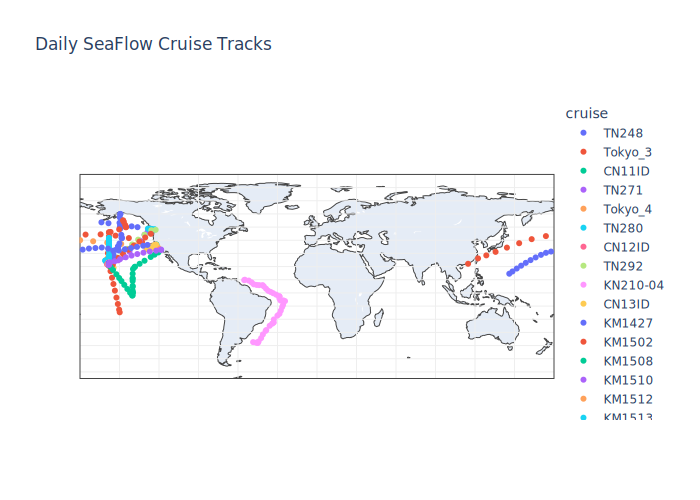

In [37]:
# adjust longitudes for plotting on plotly (international dateline)
hourly_samp['lon']=np.where(hourly_samp['lon'] < 0, hourly_samp['lon'] + 360, hourly_samp['lon'])
# plot daily averages to not explode plotly
daily = hourly_samp.groupby([pd.Grouper(key='time',freq='24H'), 'cruise']).mean().reset_index()
fig = px.scatter_geo(daily, lat='lat',lon='lon',color='cruise', title='Daily SeaFlow Cruise Tracks')

fig.update_geos(lataxis_showgrid=True, lonaxis_showgrid=True)
# focus point
lat_foc = 25
lon_foc = 360
fig.update_layout(
        geo = dict(
            projection_scale=1, #this is kind of like zoom
            center=dict(lat=lat_foc, lon=lon_foc), # this will center on the point
        )
)

fig.show('svg')

## What does the distribution of SeaFlow estimated diameter look like for different populations?

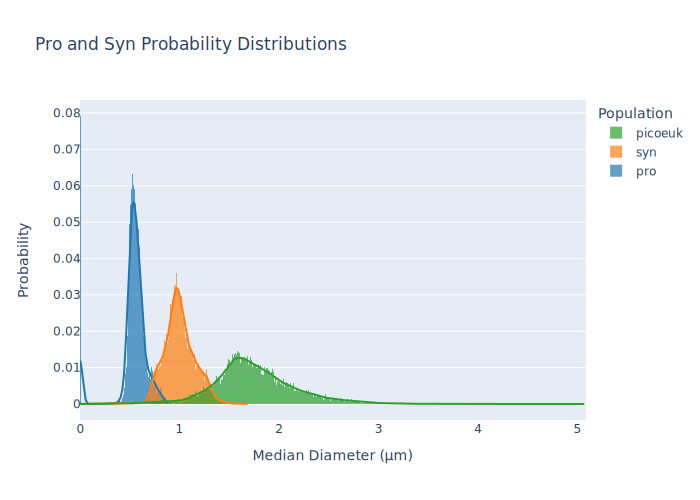

In [13]:
hist_data = [hourly_samp['diam_prochloro'], hourly_samp['diam_synecho'], 
             hourly_samp['diam_picoeuk']]
group_labels = ['pro','syn','picoeuk'] # name of the dataset

# create plot
fig = ff.create_distplot(hist_data, group_labels, bin_size=.01,show_rug=False, histnorm='probability')
# add x/ylabels and title
fig.update_layout(
    title="Pro and Syn Probability Distributions",
    xaxis_title="Median Diameter (µm)",
    yaxis_title="Probability",
    legend_title="Population"
)
fig.show('svg')

## Now we'll run a time series decomposition (TSD) model to deconvolve our cruise time series into different components!
### Here, the run_TSD function will linearly interpolate the values before running the data on a rolling hourly basis for 3 day chunks
This model is a multiplicative function, which can be written as: 
$$Y_t = T_t * S_t * R_t $$
which can also be written as:
$$log(Y_t) = log(T_t) + log(S_t) + log(R_t) $$

$S_t$ can be thought of the change in size from the diel cycle in each day. By modeling the change in size on a 24 hour cycle, we can start to see diel variation change throughout the cruise. 

### Example 1: Run the Gradients cruises through the TSD model

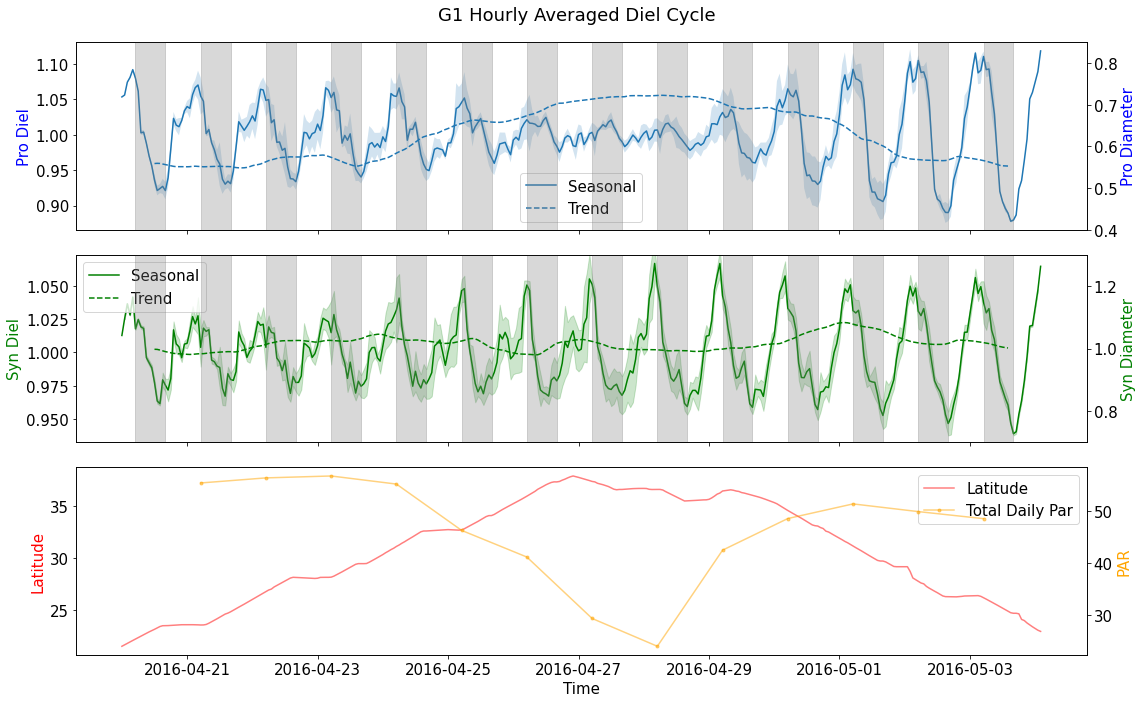

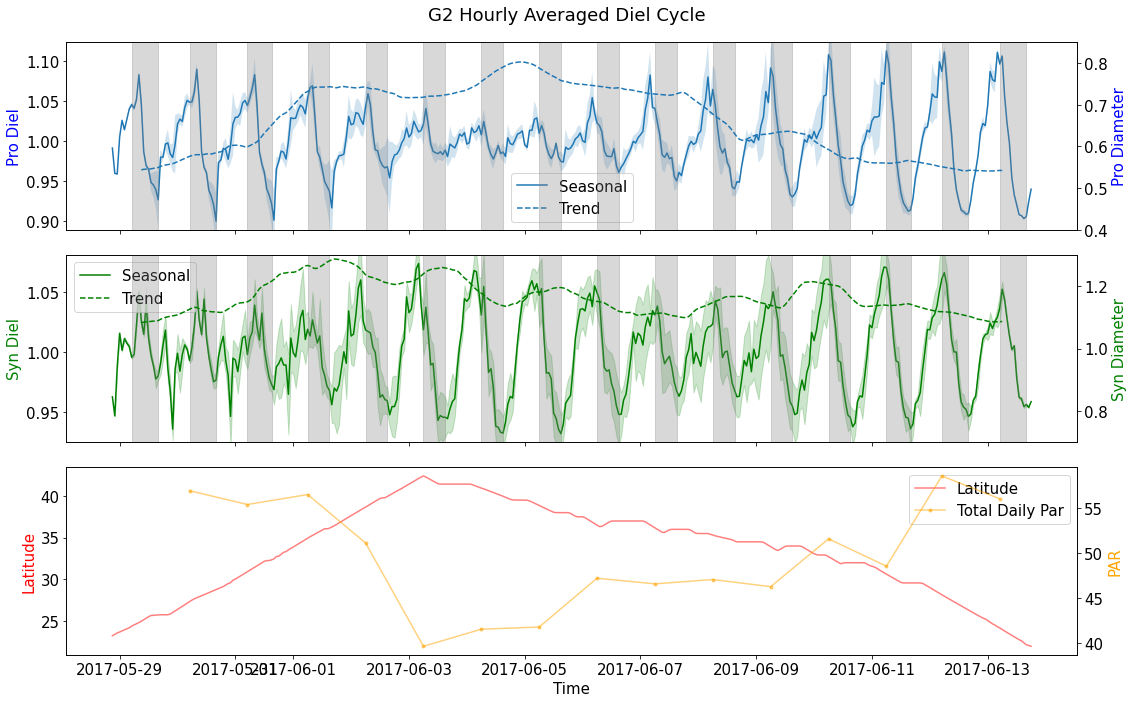

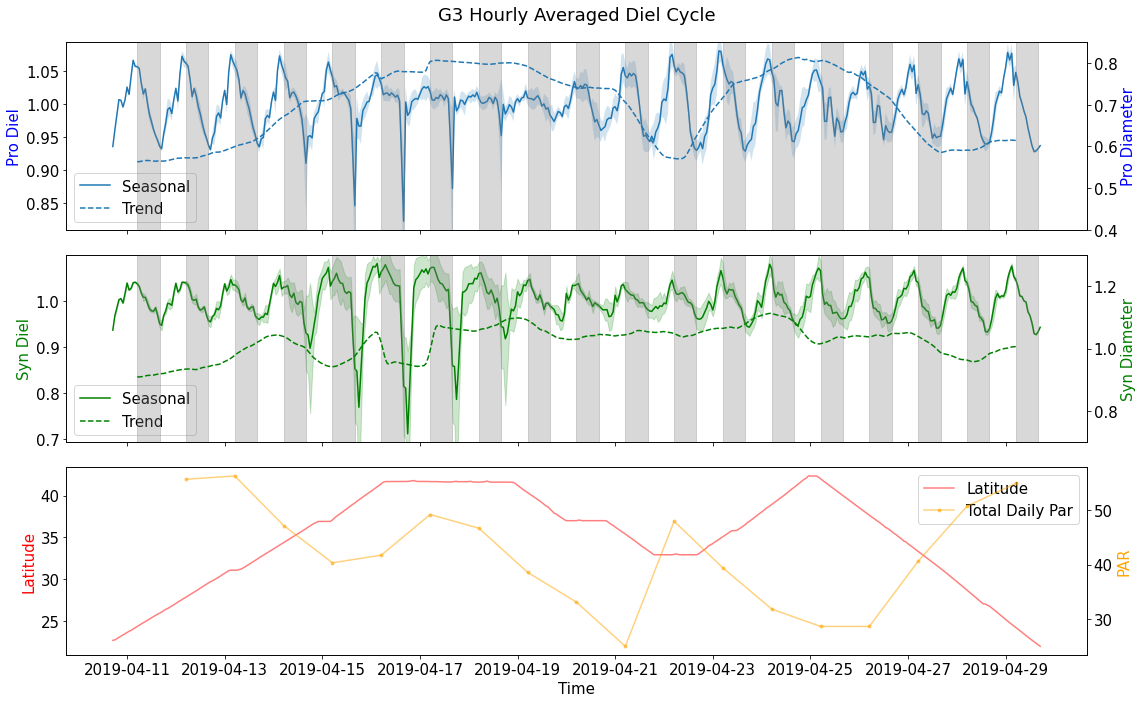

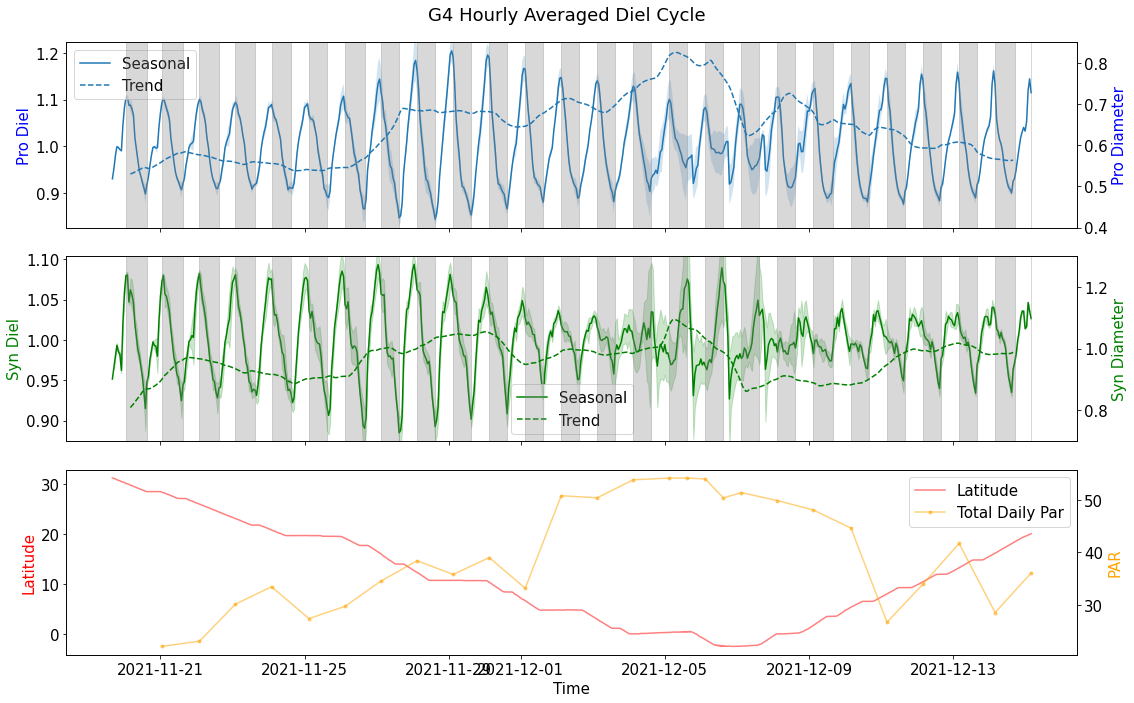

In [125]:
# pull the gradients cruises from the cruise list
gradients = ['KOK1606','MGL1704','KM1906','TN397']
cruise_list = [long_sf.loc[long_sf['cruise']==n] for n in gradients]
names = ['G1','G2','G3','G4']

for cruise, name in zip(cruise_list, names):
    seasonal, trend, resid, diel, plot0 = run_TSD(cruise, name, False)

## Analyzing the model outputs
We can also use $S_t$ as a proxy for daily cellular growth rate, and we can estimate how much cell size has changed on a diel cycle with respect to different covariates. We can approximate the daily cellular growth rate by calculating the difference of the maximum and minimum cell size per day, which we'll call the daily amplitude.
$$Amplitude = max(S_t)_d - min(S_t)_d $$ for d = day in a cruise <br>
#### Let's try it with our colocalized temperature and salinity data.

G1
G2
G3
G4


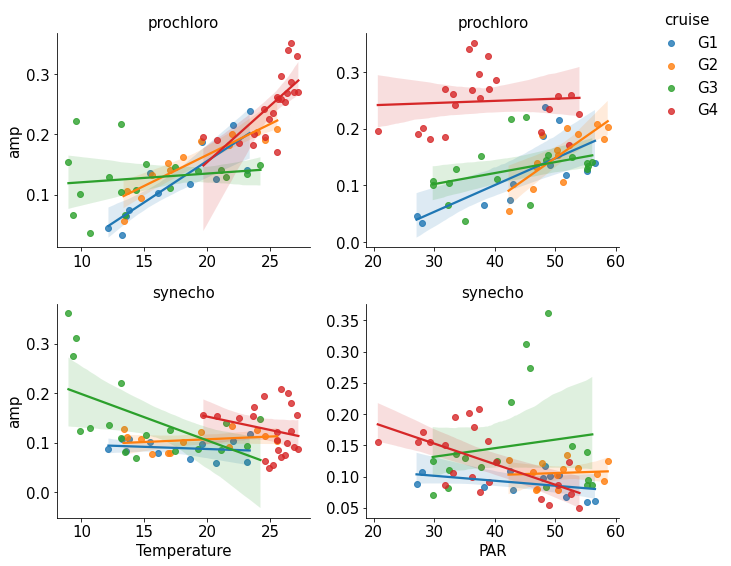

In [185]:
# run on gradients data
data = amp_temp(cruise_list, names, linreg=True)

### Temperature and PAR seem to have a relationship with Prochlorococcus. Let's try this same analysis on all the cruises with SeaFlow.

CN11ID
CN12ID
CN13ID
FK180310-1
FK180310-2
KM1427
KM1502
KM1508
KM1510
KM1512
KM1513
KM1518
KM1601
KM1602
KM1603
KM1708
KM1709
KM1712
KM1713
KM1717
KM1802
KM1821
KM1823
KM1901
KM1903
KM1906
KM1909
KM1912
KM1915
KM1917
KM1923_751
KM1924
KM2001
KM2002
KM2009
KM2010
KM2011
KM2013
KM2014
KM2101
KM2112
KN210-04
KOK1512
KOK1515
KOK1604
KOK1606
KOK1607
KOK1608
KOK1609
KOK1801
KOK1803
KOK1804
KOK1806
KOK1807
MGL1704
SR1917
TN271
TN292
TN397
TN398
Tokyo_3
Tokyo_4
TN248
TN280


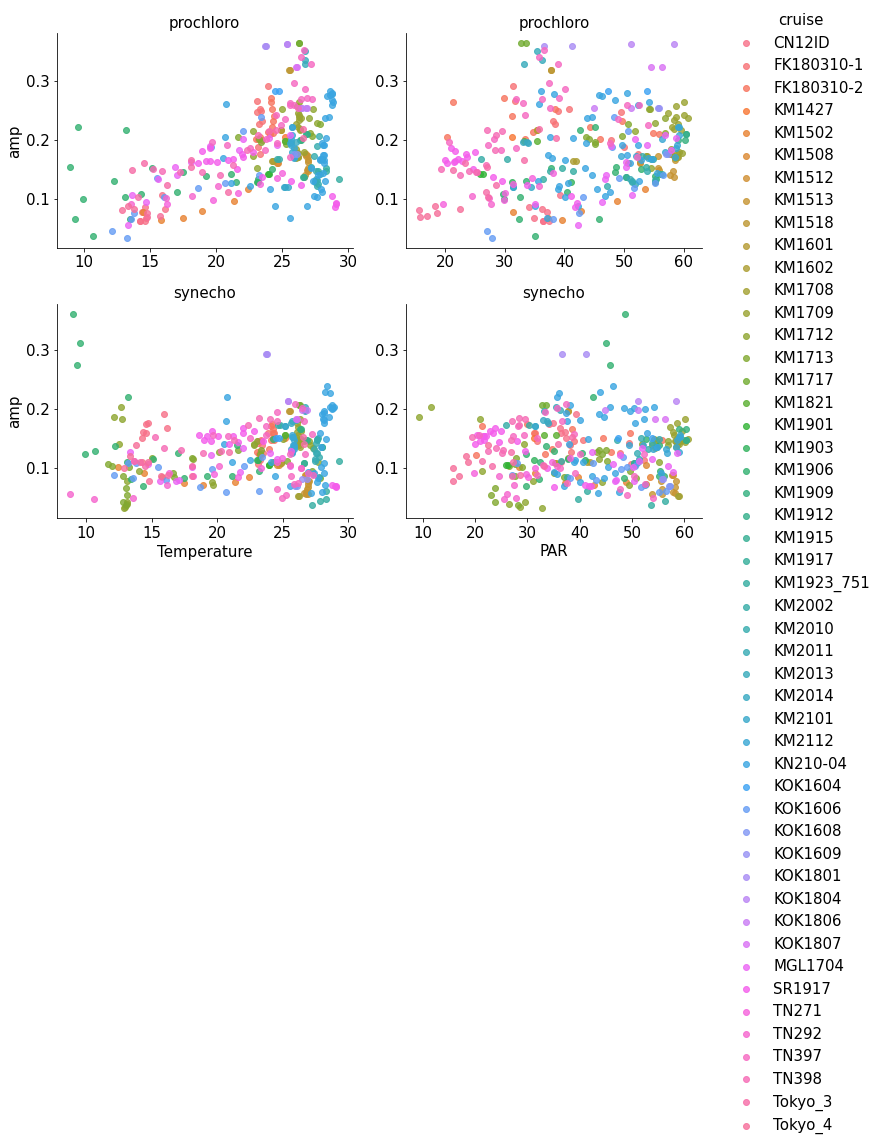

In [186]:
# run on all cruises in colocalized CMAP dataset
all_cruise_list = [long_sf.loc[long_sf['cruise']==n] for n in pd.unique(long_sf['cruise'])]
all_names = pd.unique(long_sf['cruise'])
data = amp_temp(all_cruise_list, all_names, linreg=False)

### Results:
For daily Prochlorococcus growth and temperature, there is an increase with daily growth until ~26-27ºC. The decrease in amplitude could be due to a thermal tolerance that slow Prochlorococcus daily growth above a certain temperature. Synechococcus does not seem to as strongly affected by temperature, and daily PAR effects also seem to be weaker for both populations.